In [105]:
import arviz
import numpy as np
import pandas as pd
import pystan

In [106]:
# Parameters
P = 10
N = 10 ** 4

In [107]:
# Ground truth
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)

In [108]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
X = pd.DataFrame(data)

z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
X = X.loc[:, X.columns.str.startswith('O')]
y = (z > 0).astype(int)

In [109]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ beta(1, 10);
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m(theta[p]);
      }
    }
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_9e07ee56fc623d52c3278490d479700e NOW.


In [110]:
# Fit model
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
fit = sm.sampling(data=model_data, iter=20000, chains=16)

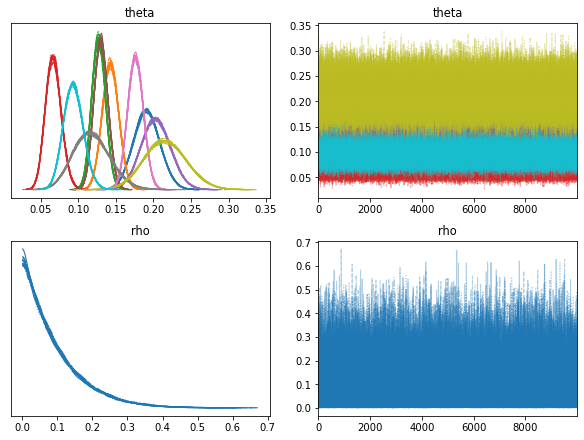

In [111]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [112]:
print(fit)
print()
print(true_transmission_rate)

Inference for Stan model: tt_mod_9e07ee56fc623d52c3278490d479700e.
16 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=160000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.19  3.1e-5   0.02   0.16   0.18   0.19    0.2   0.23 310106    1.0
theta[2]    0.14  2.0e-5   0.01   0.12   0.14   0.14   0.15   0.16 294687    1.0
theta[3]    0.13  1.7e-5 9.1e-3   0.11   0.12   0.13   0.13   0.15 301133    1.0
theta[4]    0.07  1.9e-5   0.01   0.05   0.06   0.07   0.07   0.09 317660    1.0
theta[5]     0.2  3.5e-5   0.02   0.17   0.19    0.2   0.22   0.24 316988    1.0
theta[6]    0.13  1.7e-5 9.3e-3   0.11   0.12   0.13   0.14   0.15 304811    1.0
theta[7]    0.18  1.9e-5   0.01   0.16   0.17   0.18   0.18    0.2 305462    1.0
theta[8]    0.12  4.3e-5   0.02   0.07    0.1   0.12   0.13   0.17 319921    1.0
theta[9]    0.22  5.0e-5   0.03   0.16    0.2   0.22   0.23   0.27 320296    1.0